# Классификация новостей 
Цели: классифицировать новости по категориям исходя из их заголовка \
Датасет: https://www.kaggle.com/datasets/shivam271882/news-classification-dataset \
Датасет представляет из себя csv файл с столбцами headline, category, authors, short_description, отвечающие соответсвенно за заголовок, категорию, автора и короткое описание \
Чтобы не усложнять задачу будем использовать информацию только о заголовках, не трогая автора и короткое описание \
Размер датасета: 200853 семплов, но вследствии ограничения на вычислительные условия возмём только 50000 \
Метрики: accuracy, f1, roc_auc 

In [47]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import re
import string

from tqdm.notebook import tqdm 
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer

import time
import optuna

import cudf
import cupy
from cuml.feature_extraction.text import TfidfVectorizer as cuTfidVectorizer
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.feature_extraction.text import CountVectorizer as cuCountVectorizer

from catboost import CatBoostClassifier, Pool

sns.set()

In [48]:
seed = 42 # Для воспроизводимости 

In [49]:
data = pd.read_csv('/kaggle/input/news-classification-dataset/News.csv').sample(50000, random_state=seed)
data.head()

,headline,category,authors,short_description
56274,Shooting Rampage Results In 'Mass Casualties'...,CRIME,,ORLANDO Fla. June 12 (Reuters) - A gunman kil...
9929,Donald Trump Lashes Out At CNN ABC Over Repor...,POLITICS,Mollie Reilly,The president criticized the fake news media ...
163271,Model Kate Moss Walks Louis Vuitton RTW Fall ...,STYLE & BEAUTY,Catherine Garvin Contributor\nWriter Author H...,Golden girl model Kate Moss wowed in her usua...
190013,7 Ways Single Moms Cope With Loneliness authors,DIVORCE,,//www.circleofmoms.com/article/7-ways-single-m...
13564,Sen. Sherrod Brown,POLITICS,Steve Bannon 'Is A White Supremacist' authors,//www.huffingtonpost.com/entry/steve-bannon-wh...


# EDA

Размер классов

In [50]:
labels, freqs = np.unique(data['category'], return_counts=True)

sorted_freqs_ix = np.argsort(freqs)[::-1]

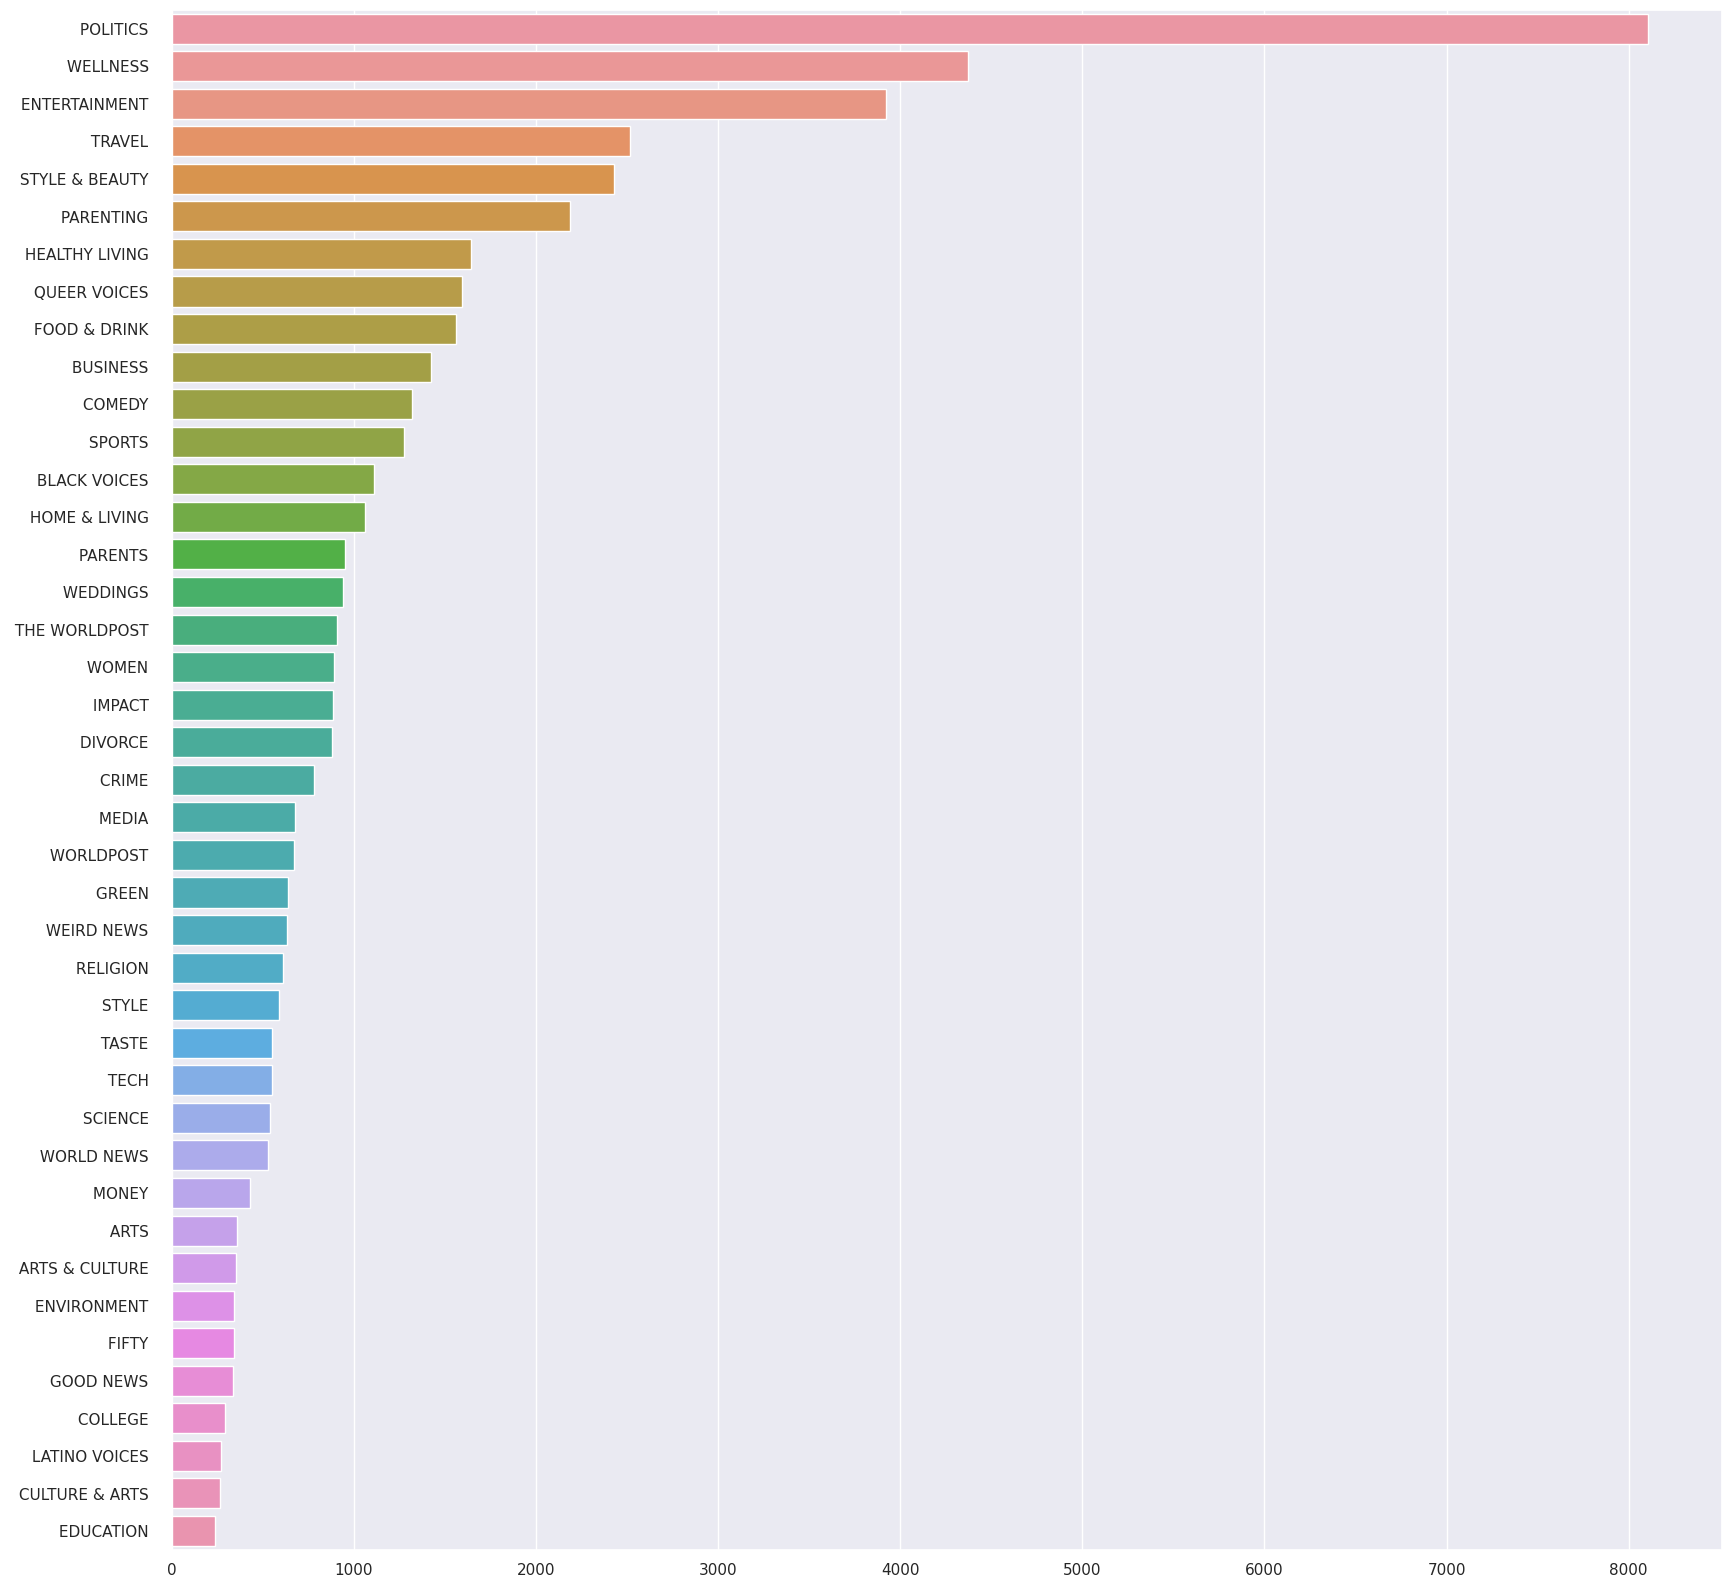

In [52]:
plt.figure(figsize=(20, 20))
sns.barplot(y=labels[sorted_freqs_ix], x=freqs[sorted_freqs_ix]);

Из графика понятно, что классы распределенны неравномерно и большинство новостей из тренировочного сета относятся к политике

Перед дальнейшим этапом анализа проведём небольшую предобработку текст

* приведём всё к нижнему регистру
* удалим все знаки препинания, цифры и нелатинские символы
* удалим все stopwords

In [53]:
stop = set(stopwords.words('english'))

In [54]:
def clean_text(text):
    text = text.lower()  
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)    
    text = re.sub("([^\x00-\x7F])+", " ", text)
    return word_tokenize(text)


class ClearText(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        return self 
    
    def transform(self, X):
        res = list(map(clean_text, X))
        res = list(map(lambda sentence: list(filter(lambda word: word not in stop, sentence)), res))
        return res 

In [55]:
clear_text = ClearText()
preprocessed_text = clear_text.fit_transform(data['headline'])

Теперь можно построить облако слов

In [56]:
corpus = ''

for row in tqdm(preprocessed_text):
    corpus += ' '.join(row) + ' '

  0%|          | 0/50000 [00:00<?, ?it/s]

In [57]:
wordcloud = WordCloud().generate(corpus)

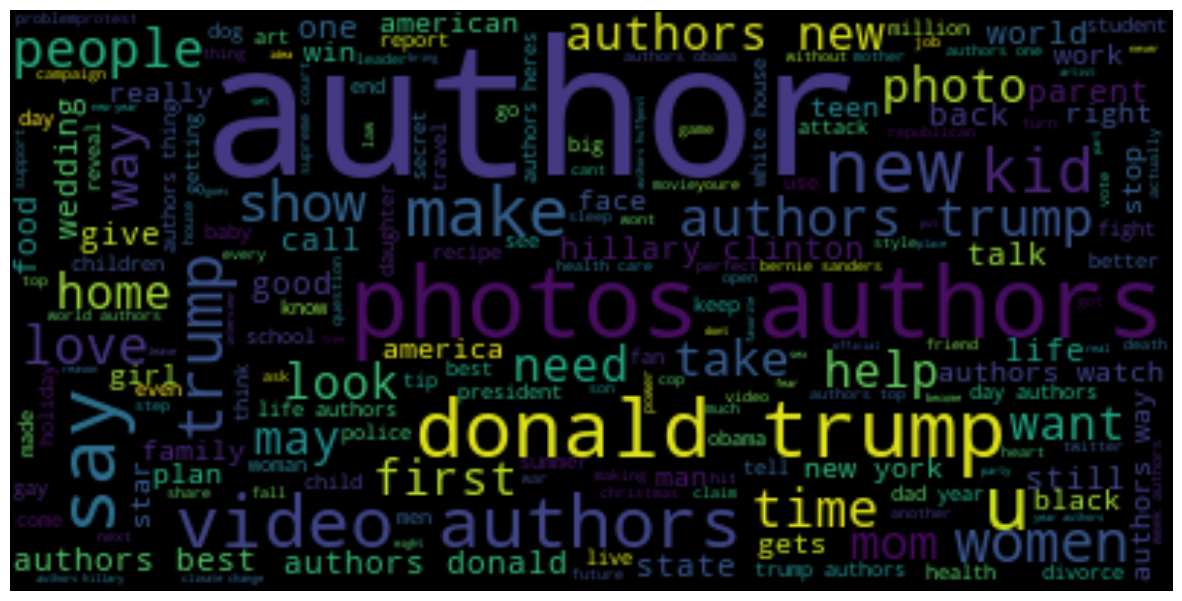

In [58]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Теперь разделим данные на тренировочную и тестовые выборки \
Будем делить в стандартных пропрциях sklearn, а именно train=0.7 и test = 0.3 \
Так же будем использовать стратифицированное разделение, чтобы и в трейне и в тесте пристуствовали примеры каждого класса \
Дополнительно перемешиваем данные

In [59]:
train, test = train_test_split(data, stratify=data['category'], shuffle=True, random_state=seed)
train.shape, test.shape

((37500, 4), (12500, 4))

In [60]:
clear_text = ClearText()
train_processed = clear_text.fit_transform(train['headline'])
test_processed = clear_text.transform(test['headline'])

Теперь применим стеммизацию 

In [61]:
snow_stemmer = SnowballStemmer(language='english')
stemmed_train= list(map(lambda x: ' '.join([snow_stemmer.stem(i) for i in x]), train_processed))
stemmed_test= list(map(lambda x: ' '.join([snow_stemmer.stem(i) for i in x]), test_processed))

Добавим столбец с предобработанным текстом в датасет и удалим ненужные столбцы

In [62]:
train['tokens'] = stemmed_train
train.drop(columns=['headline', 'authors', 'short_description'], inplace=True)
test['tokens'] = stemmed_test
test.drop(columns=['headline', 'authors', 'short_description'], inplace=True)

Теперь закодируем категории новостей в числа: 0, 1, 2, 3, ... для обучения моделий 

In [63]:
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train['category'])
train.drop(columns=['category'], inplace=True)

test['label'] = label_encoder.transform(test['category'])
test.drop(columns=['category'], inplace=True)

Разобъем тренировочную выборки на две части (так же в соотношении 0.7:0.3)\
Большая часть будет так же называться тренировочной и использоваться для обучения моделей \
Меньшая для сравнения качества между моделями

In [64]:
X_train, X_val, y_train, y_val = train_test_split(train['tokens'], train['label'], stratify=train['label'], random_state=seed)

In [65]:
X_train.shape, X_val.shape

((28125,), (9375,))

In [66]:
model_selection_df = pd.DataFrame(columns=['clf', 'name', 'train_time', 'eval_time', 'accuracy','f1', 'roc_auc'])

In [67]:
def get_scores(clf, X_val, y_true, f1_average='micro', row_auc_average='macro', multi_class='ovo', cuda=False):
    start = time.time()
    probas = clf.predict_proba(X_val)
    if cuda:
        probas = probas.get()
    end = time.time()
    
    y_pred = probas.argmax(1)
    return {
         'f1': f1_score(y_true, y_pred, average=f1_average),
         'accuracy': accuracy_score(y_true, y_pred),
         'roc_auc': roc_auc_score(y_true, probas, average=row_auc_average, multi_class=multi_class),
         'eval_time': end - start
    }

In [68]:
def fit_evaluate_model(clf, name, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, cuda=False):
    res = {'name': name, 'clf': clf}
    
    print('Training started...')
    start = time.time()
    clf.fit(X_train, y_train);
    end = time.time()
    print(f'Training ended. Training time {end - start}s')

    res['train_time'] = end - start 
    
    print('\n')
    print('Evaluation started...')
    scores = get_scores(clf, X_val=X_val, y_true=y_val, cuda=cuda)
    res = {**res, **scores}
    print(f'Evaluation ended...')
    return res

Построим бейзлайн, попробуем метод близжайших соседей

In [69]:
baseline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('neighbors', KNeighborsClassifier())
])

res = fit_evaluate_model(baseline, 'count_vectorizer + neighbors')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 0.391554594039917s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1956133450.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


Попробуем подобрать гиперпараметры с помощью Grid Search

In [71]:
vectorizerd_train = CountVectorizer().fit_transform(X_train)

params = {
    "n_neighbors": [2, 5, 10],
    "weights": ['uniform', 'distance']
}

knn_gs = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='f1_micro')

knn_gs.fit(vectorizerd_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

In [73]:
knn_gs.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

Обучим модель с наиболее эффективными параметрами и измерим качество

In [74]:
knn_best = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('neighbors', KNeighborsClassifier(**knn_gs.best_params_))
])

res = fit_evaluate_model(knn_best, 'count_vectorizer + neighbors(best params)')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 0.3515806198120117s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1976733738.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


Попробуем теперь Decision Tree

In [75]:
tree = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('decision tree', DecisionTreeClassifier(random_state=seed))
])

res = fit_evaluate_model(tree, 'count_vectorizer + decision tree')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 14.575434446334839s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1655997863.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


Попробуем заменить Энкодер на более сложный 

In [76]:
tree_tfidf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('decision tree', DecisionTreeClassifier(random_state=seed))
])

res = fit_evaluate_model(tree_tfidf, 'tf_idf + decision tree')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 16.371749877929688s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1144415148.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [77]:
model_selection_df.sort_values('f1', ascending=False)

,clf,name,train_time,eval_time,accuracy,f1,roc_auc
2,"(CountVectorizer(), DecisionTreeClassifier(ran...",count_vectorizer + decision tree,14.575434,0.120723,0.387200,0.387200,0.623913
3,"(TfidfVectorizer(), DecisionTreeClassifier(ran...",tf_idf + decision tree,16.371750,0.119068,0.336107,0.336107,0.600715
1,"(CountVectorizer(), KNeighborsClassifier(n_nei...",count_vectorizer + neighbors(best params),0.351581,9.218424,0.245013,0.245013,0.621137
0,"(CountVectorizer(), KNeighborsClassifier())",count_vectorizer + neighbors,0.391555,9.323137,0.218240,0.218240,0.594458


Попробуем логистическую регрессию

In [79]:
log_reg_tfidf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('logistic regression', LogisticRegression(random_state=seed, solver='saga', max_iter=250))
])

res = fit_evaluate_model(log_reg_tfidf, 'tf_idf + logistic regression')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 2.1896770000457764s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/3616589455.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [80]:
log_reg = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('logistic regression', LogisticRegression(random_state=seed, solver='saga', max_iter=250))
])

res = fit_evaluate_model(log_reg, 'count_vectorizer + logistic regression')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training ended. Training time 20.20260524749756s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/3317499790.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [81]:
model_selection_df.sort_values('f1', ascending=False)

,clf,name,train_time,eval_time,accuracy,f1,roc_auc
5,"(CountVectorizer(), LogisticRegression(max_ite...",count_vectorizer + logistic regression,20.202605,0.111697,0.498987,0.498987,0.882979
4,"(TfidfVectorizer(), LogisticRegression(max_ite...",tf_idf + logistic regression,2.189677,0.114365,0.474880,0.474880,0.877248
2,"(CountVectorizer(), DecisionTreeClassifier(ran...",count_vectorizer + decision tree,14.575434,0.120723,0.387200,0.387200,0.623913
3,"(TfidfVectorizer(), DecisionTreeClassifier(ran...",tf_idf + decision tree,16.371750,0.119068,0.336107,0.336107,0.600715
1,"(CountVectorizer(), KNeighborsClassifier(n_nei...",count_vectorizer + neighbors(best params),0.351581,9.218424,0.245013,0.245013,0.621137
0,"(CountVectorizer(), KNeighborsClassifier())",count_vectorizer + neighbors,0.391555,9.323137,0.218240,0.218240,0.594458


попробуем подобрать параметры с помощью Grid Search

In [83]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 5],
}

log_reg_gs = GridSearchCV(LogisticRegression(solver='saga', max_iter=250), params, cv=3, scoring='f1_micro')

log_reg_gs.fit(vectorizerd_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=250, solver='saga'),
             param_grid={'C': [0.1, 1, 5], 'penalty': ['l1', 'l2']},
             scoring='f1_micro')

In [84]:
log_reg_gs.best_params_

{'C': 1, 'penalty': 'l2'}

In [86]:
log_reg_best = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('logistic regression', LogisticRegression(random_state=seed, solver='saga', max_iter=250, **log_reg_gs.best_params_))
])

res = fit_evaluate_model(log_reg_best, 'count_vectorizer + logistic regression(best params)')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training ended. Training time 20.232635259628296s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/2043199880.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


Теперь попробуем обучить наивный баес \
Так как наивный баес не поддерживает работу с sparse матрица, сделаем дополнительный Estimator, для преобразования sparse матриц к dense

In [89]:
class DenseTransformer(TransformerMixin):
    def __init__(self, cuda=False):
        self.cuda = cuda 
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        if self.cuda:
            return X.todense()
        return np.asarray(X.todense())

In [90]:
naive_bias_tfidf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ("dense_transformer", DenseTransformer()),
    ('naive_bias', GaussianNB())
])

res = fit_evaluate_model(naive_bias_tfidf, 'tf_idf + naive_bias')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 8.318364143371582s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1518396438.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [91]:
naive_bias = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ("dense_transformer", DenseTransformer()),
    ('naive_bias', GaussianNB())
])

res = fit_evaluate_model(naive_bias, 'count_vectorizer + naive_bias')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 9.705596446990967s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/1061790587.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [92]:
model_selection_df[['name', 'f1', 'accuracy', 'roc_auc', 'train_time', 'eval_time']].sort_values('f1', ascending=False)

,name,f1,accuracy,roc_auc,train_time,eval_time
5,count_vectorizer + logistic regression,0.498987,0.498987,0.882979,20.202605,0.111697
6,count_vectorizer + logistic regression(best pa...,0.498987,0.498987,0.882979,20.232635,0.112622
4,tf_idf + logistic regression,0.474880,0.474880,0.877248,2.189677,0.114365
2,count_vectorizer + decision tree,0.387200,0.387200,0.623913,14.575434,0.120723
3,tf_idf + decision tree,0.336107,0.336107,0.600715,16.371750,0.119068
7,tf_idf + naive_bias,0.266880,0.266880,0.588821,8.318364,41.279928
8,count_vectorizer + naive_bias,0.260907,0.260907,0.591930,9.705596,49.008056
1,count_vectorizer + neighbors(best params),0.245013,0.245013,0.621137,0.351581,9.218424
0,count_vectorizer + neighbors,0.218240,0.218240,0.594458,0.391555,9.323137


Теперь попробуем более сложные алгоритмы \
Вследствии, размера выборки и сложности алгоритмов, будем использовать cuml вместо sklearn, потому что данная библиотека позволяет обучать модели на GPU, что значительно ускорить работу \
Начнём с Random Forest

In [93]:
rfc = Pipeline([
    ('count_vectorizer', cuCountVectorizer()),
    ('dense_transformer', DenseTransformer(cuda=True)),
    ('random_forest_classifier', cuRFC())
])

res = fit_evaluate_model(rfc, 'count_vectorizer + random_forest', cuda=True)
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 23.766300439834595s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/2749562612.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [94]:
rfc_tfidf = Pipeline([
    ('tfidf', cuTfidVectorizer()),
    ('dense_transformer', DenseTransformer(cuda=True)),
    ('random_forest_classifier', cuRFC())
])

res = fit_evaluate_model(rfc, 'tfidf + random_forest', cuda=True)
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 4.648017883300781s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/2286353477.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [95]:
model_selection_df[['name', 'f1', 'accuracy', 'roc_auc', 'train_time', 'eval_time']].sort_values('f1', ascending=False)

,name,f1,accuracy,roc_auc,train_time,eval_time
5,count_vectorizer + logistic regression,0.498987,0.498987,0.882979,20.202605,0.111697
6,count_vectorizer + logistic regression(best pa...,0.498987,0.498987,0.882979,20.232635,0.112622
4,tf_idf + logistic regression,0.474880,0.474880,0.877248,2.189677,0.114365
2,count_vectorizer + decision tree,0.387200,0.387200,0.623913,14.575434,0.120723
3,tf_idf + decision tree,0.336107,0.336107,0.600715,16.371750,0.119068
7,tf_idf + naive_bias,0.266880,0.266880,0.588821,8.318364,41.279928
8,count_vectorizer + naive_bias,0.260907,0.260907,0.591930,9.705596,49.008056
1,count_vectorizer + neighbors(best params),0.245013,0.245013,0.621137,0.351581,9.218424
0,count_vectorizer + neighbors,0.218240,0.218240,0.594458,0.391555,9.323137
9,count_vectorizer + random_forest,0.198187,0.198187,0.792144,23.766300,1.393530


попробуем оптимизировать гиперпараметры с помощью optuna

In [96]:
def objective(trial):
    params = {
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }

    rfc = Pipeline([
        ('count_vectorizer', cuCountVectorizer()),
        ('dense_transformer', DenseTransformer(cuda=True)),
        ('random_forest_classifier', cuRFC(**params))
    ])
    
    rfc.fit(X_train, y_train)
    pred = rfc.predict(X_val)
    score = f1_score(y_val, pred.get(), average='micro')

    return score

In [97]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-25 20:51:30,101] A new study created in memory with name: no-name-cf5f5bf7-31ef-4d1a-9281-ef8340db5aad
[I 2023-05-25 20:51:33,967] Trial 0 finished with value: 0.16234666666666667 and parameters: {'min_samples_leaf': 8, 'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.16234666666666667.
[I 2023-05-25 20:51:38,133] Trial 1 finished with value: 0.1808 and parameters: {'min_samples_leaf': 6, 'max_depth': 11, 'min_samples_split': 4}. Best is trial 1 with value: 0.1808.
[I 2023-05-25 20:51:42,189] Trial 2 finished with value: 0.17994666666666667 and parameters: {'min_samples_leaf': 2, 'max_depth': 11, 'min_samples_split': 6}. Best is trial 1 with value: 0.1808.
[I 2023-05-25 20:51:46,885] Trial 3 finished with value: 0.21738666666666667 and parameters: {'min_samples_leaf': 10, 'max_depth': 18, 'min_samples_split': 2}. Best is trial 3 with value: 0.21738666666666667.
[I 2023-05-25 20:51:51,424] Trial 4 finished with value: 0.19008 and parameters: {'min_sample

Number of finished trials:  20
Best trial:
  Value:  0.22624
  Params: 
    min_samples_leaf: 9
    max_depth: 20
    min_samples_split: 3


In [114]:
best_rfc = Pipeline([
    ('count_vectorizer', cuCountVectorizer()),
    ('dense_transformer', DenseTransformer(cuda=True)),
    ('random_forest_classifier', cuRFC(**trial.params))
])

res = fit_evaluate_model(best_rfc, 'count_vectorizer + random_forest(best)', cuda=True)
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 4.907059192657471s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/683126870.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [115]:
model_selection_df[['name', 'f1', 'accuracy', 'roc_auc', 'train_time', 'eval_time']].sort_values('f1', ascending=False)

,name,f1,accuracy,roc_auc,train_time,eval_time
5,count_vectorizer + logistic regression,0.498987,0.498987,0.882979,20.202605,0.111697
6,count_vectorizer + logistic regression(best pa...,0.498987,0.498987,0.882979,20.232635,0.112622
4,tf_idf + logistic regression,0.474880,0.474880,0.877248,2.189677,0.114365
2,count_vectorizer + decision tree,0.387200,0.387200,0.623913,14.575434,0.120723
3,tf_idf + decision tree,0.336107,0.336107,0.600715,16.371750,0.119068
7,tf_idf + naive_bias,0.266880,0.266880,0.588821,8.318364,41.279928
8,count_vectorizer + naive_bias,0.260907,0.260907,0.591930,9.705596,49.008056
1,count_vectorizer + neighbors(best params),0.245013,0.245013,0.621137,0.351581,9.218424
11,count_vectorizer + random_forest(best),0.226240,0.226240,0.796350,4.907059,0.168910
0,count_vectorizer + neighbors,0.218240,0.218240,0.594458,0.391555,9.323137


Теперь попробуем использовать градиентный бустинг. Для этого воспользуемся библиотекой catboost

In [116]:
train_pool = Pool(pd.DataFrame(X_train), y_train, text_features=['tokens'])
val_pool = Pool(pd.DataFrame(X_val), y_val, text_features=['tokens'])

In [117]:
model = CatBoostClassifier(iterations=2000,
                           early_stopping_rounds=50,
                           task_type="GPU",
                           loss_function='MultiClass',
                           devices='0:1')


train_time_start = time.time()
model.fit(train_pool, eval_set=val_pool)
train_time_end = time.time()

Learning rate set to 0.108803
0:	learn: 3.1453725	test: 3.0681362	best: 3.0681362 (0)	total: 217ms	remaining: 7m 14s
1:	learn: 3.0405567	test: 2.9588367	best: 2.9588367 (1)	total: 449ms	remaining: 7m 28s
2:	learn: 2.9434550	test: 2.8542308	best: 2.8542308 (2)	total: 693ms	remaining: 7m 41s
3:	learn: 2.8829311	test: 2.7917079	best: 2.7917079 (3)	total: 879ms	remaining: 7m 18s
4:	learn: 2.8302833	test: 2.7371652	best: 2.7371652 (4)	total: 1.05s	remaining: 6m 58s
5:	learn: 2.7875572	test: 2.6930721	best: 2.6930721 (5)	total: 1.26s	remaining: 6m 58s
6:	learn: 2.7526872	test: 2.6555783	best: 2.6555783 (6)	total: 1.45s	remaining: 6m 52s
7:	learn: 2.7245403	test: 2.6270800	best: 2.6270800 (7)	total: 1.64s	remaining: 6m 47s
8:	learn: 2.6983867	test: 2.5999798	best: 2.5999798 (8)	total: 1.83s	remaining: 6m 45s
9:	learn: 2.6723419	test: 2.5726804	best: 2.5726804 (9)	total: 2s	remaining: 6m 38s
10:	learn: 2.6400856	test: 2.5351467	best: 2.5351467 (10)	total: 2.14s	remaining: 6m 27s
11:	learn: 2.6

In [118]:
val_time_start = time.time()
probas = model.predict_proba(val_pool)
preds = probas.argmax(-1)

scores = {'f1': f1_score(y_val, preds, average='micro'),
          'accuracy': accuracy_score(y_val, preds),
          'roc_auc': roc_auc_score(y_val, probas, multi_class='ovo')
         }
          
val_time_end = time.time()

In [119]:
model_selection_df = model_selection_df.append({
    'clf': model,
    'name': 'gradient boosting',
    'train_time': train_time_end - train_time_start,
    'eval_time': val_time_end - val_time_start,
    **scores
}, ignore_index=True)

/tmp/ipykernel_32/1909455380.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append({


Последней используемой моделью, станет MLP. К сожалению, не удалось найти его в cuml, поэтому пришлось обучать на CPU с помощью sklearn

In [121]:
mlp = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('mlp', MLPClassifier(early_stopping=True, max_iter=20))

])

res = fit_evaluate_model(mlp, 'count_vectorizer + mlp')
model_selection_df = model_selection_df.append(res, ignore_index=True)

Training started...
Training ended. Training time 94.88535141944885s


Evaluation started...
Evaluation ended...


/tmp/ipykernel_32/3510583091.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_selection_df = model_selection_df.append(res, ignore_index=True)


In [122]:
model_selection_df[['name', 'f1', 'accuracy', 'roc_auc', 'train_time', 'eval_time']].sort_values('f1', ascending=False)

,name,f1,accuracy,roc_auc,train_time,eval_time
13,count_vectorizer + mlp,0.510613,0.510613,0.885221,94.885351,0.200530
12,gradient boosting,0.503360,0.503360,0.889293,234.438897,1.864359
5,count_vectorizer + logistic regression,0.498987,0.498987,0.882979,20.202605,0.111697
6,count_vectorizer + logistic regression(best pa...,0.498987,0.498987,0.882979,20.232635,0.112622
4,tf_idf + logistic regression,0.474880,0.474880,0.877248,2.189677,0.114365
2,count_vectorizer + decision tree,0.387200,0.387200,0.623913,14.575434,0.120723
3,tf_idf + decision tree,0.336107,0.336107,0.600715,16.371750,0.119068
7,tf_idf + naive_bias,0.266880,0.266880,0.588821,8.318364,41.279928
8,count_vectorizer + naive_bias,0.260907,0.260907,0.591930,9.705596,49.008056
1,count_vectorizer + neighbors(best params),0.245013,0.245013,0.621137,0.351581,9.218424


Самая лучшая модель на текущий момент CounteVectorizer + MultiLayerPerceptron

Обучим модель на полной выборке и измерим качество на тесте

In [123]:
final = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('mlp', MLPClassifier(early_stopping=True, max_iter=20))

])


final.fit(train['tokens'], train['label'])

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('mlp', MLPClassifier(early_stopping=True, max_iter=20))])

In [125]:
get_scores(clf=final, X_val=test['tokens'], y_true=test['label'])

{'f1': 0.5244,
 'accuracy': 0.5244,
 'roc_auc': 0.8927239247534557,
 'eval_time': 0.16376328468322754}

В качестве демонстрации работы попробуем классифицировать следующую новость: 
**Top 10 tasty recipes**

делаем предобработку

In [126]:
exp = ['Top 10 tasty recipes']

preprocessed_exp = clear_text.fit_transform(exp)
preprocessed_exp = list(map(lambda x: ' '.join([snow_stemmer.stem(i) for i in x]), preprocessed_exp))

Получаем индекс вероятной категории

In [127]:
pred_exp_ix = final.predict(preprocessed_exp)
pred_exp_ix

array([13])

Используем LabelEncoder для обратного преобразования индекса в категорию

In [128]:
label_encoder.inverse_transform(pred_exp_ix)

array([' FOOD & DRINK  '], dtype=object)

Модель правильно классифицировала эту новость!

Ещё один пример \
Новость: How to be healthy

In [129]:
exp = ['How to be healthy']

preprocessed_exp = clear_text.fit_transform(exp)
preprocessed_exp = list(map(lambda x: ' '.join([snow_stemmer.stem(i) for i in x]), preprocessed_exp))

pred_exp_ix = final.predict(preprocessed_exp)

label_encoder.inverse_transform(pred_exp_ix)

array([' WELLNESS  '], dtype=object)

И это правильный ответ

последний пример

In [130]:
exp = ['Biography of the best football player']

preprocessed_exp = clear_text.fit_transform(exp)
preprocessed_exp = list(map(lambda x: ' '.join([snow_stemmer.stem(i) for i in x]), preprocessed_exp))

pred_exp_ix = final.predict(preprocessed_exp)

label_encoder.inverse_transform(pred_exp_ix)

array([' SPORTS  '], dtype=object)

Выводы: 
* Наиболее эффективно себя показал MLP, показав f1 на 0.01 выше чем у близжайшего конкурента
* Можно сделать вывод, что даже простая комбинация CounterVectorizer + MLP может дать достаточно приличные результаты и правильно классифицировать новости
* Можно так же заметить, что не всегда более сложные алгоритмы дают лучшие результаты, так RandomForest(который считается довольно сложным алгоритмом, состоящим из множества маленьких) показал худшие результаты чем другие модели
* Можно заметить, что линейные модели показывают, наиболее высокие результаты в данной задаче, одной из причин для этого, может быть неспособность к экстраполяции у некоторых других алгоритмов

Пути развития: 
* Использовать не только заголовки, но и описание новости(и возможно даже автора)
* Обучать модели на всей выборке, а не только 50000 семплах
* Следует дальше пробовать нейронные сети, например RNN(GRU или LSTM), CNN, RNN with Attention, Transformers
* Попробовать использовать небольшие предобученные модели(roberta, distillbert, deberta)
* Попробовать связку эмбеддинги предобученной модели + какой-нибудь из алгоритмов выше(например градиентный бустинг)
* Попробовать подобрать гиперпараметры для градиентного бустинга и MLP с помощью optune
* Попробовать заняться feature engineering-ом, например, классифицировать каждый заголовок по интенту и добавить это как отдельную фичу
* Попробовать использовать LLM(например GPT3) и классифицировать с помощью подбора промптов
* Попробовать дообучить LLM с помощью одного из следующих методов: p-tuning, prefix-tuning, lora, adaptors 